# Notes on Hierarchical Hilbert Space Gaussian Processes

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random, vmap
from jaxtyping import Array, Float32, UInt32
from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
from numpyro.handlers import scope
from numpyro.infer import Predictive
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

In [2]:
n = 300
x = jnp.linspace(0, 1, n)

In [3]:
def generate_single_group_data(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> Float32[Array, " n"]:
    """Generate one dimensional data for a single group.

    Parameters
    ----------
    rng_key : UInt32[Array, "2"]
        JAX random key.
    x : Float32[Array, " n"]
        Input domain data.

    Returns
    -------
    Float32[Array, " n"]
        Output data.
    """
    a1, a2, b = random.uniform(rng_key, minval=4, maxval=7, shape=(3,))
    return jnp.sin((a1 * jnp.pi) * x) + jnp.cos((a2 * jnp.pi) * x) + b


def dgg(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> tuple[Float32[Array, " n"], Float32[Array, " n"], Float32[Array, " n"]]:
    f_g = generate_single_group_data(rng_key, x)
    f = jnp.sin((4 * jnp.pi) * x) + jnp.sin((7 * jnp.pi) * x)
    noise = random.normal(rng_key, shape=(n,)) * 0.3
    y = f + f_g + noise
    return f_g, f, y


n_groups = 5

rng_key, rng_subkey = random.split(rng_key)

f_g, f, y = vmap(dgg)(random.split(rng_subkey, n_groups), jnp.tile(x, (n_groups, 1)))

assert f_g.shape == (n_groups, n)
assert f.shape == (n_groups, n)
assert y.shape == (n_groups, n)

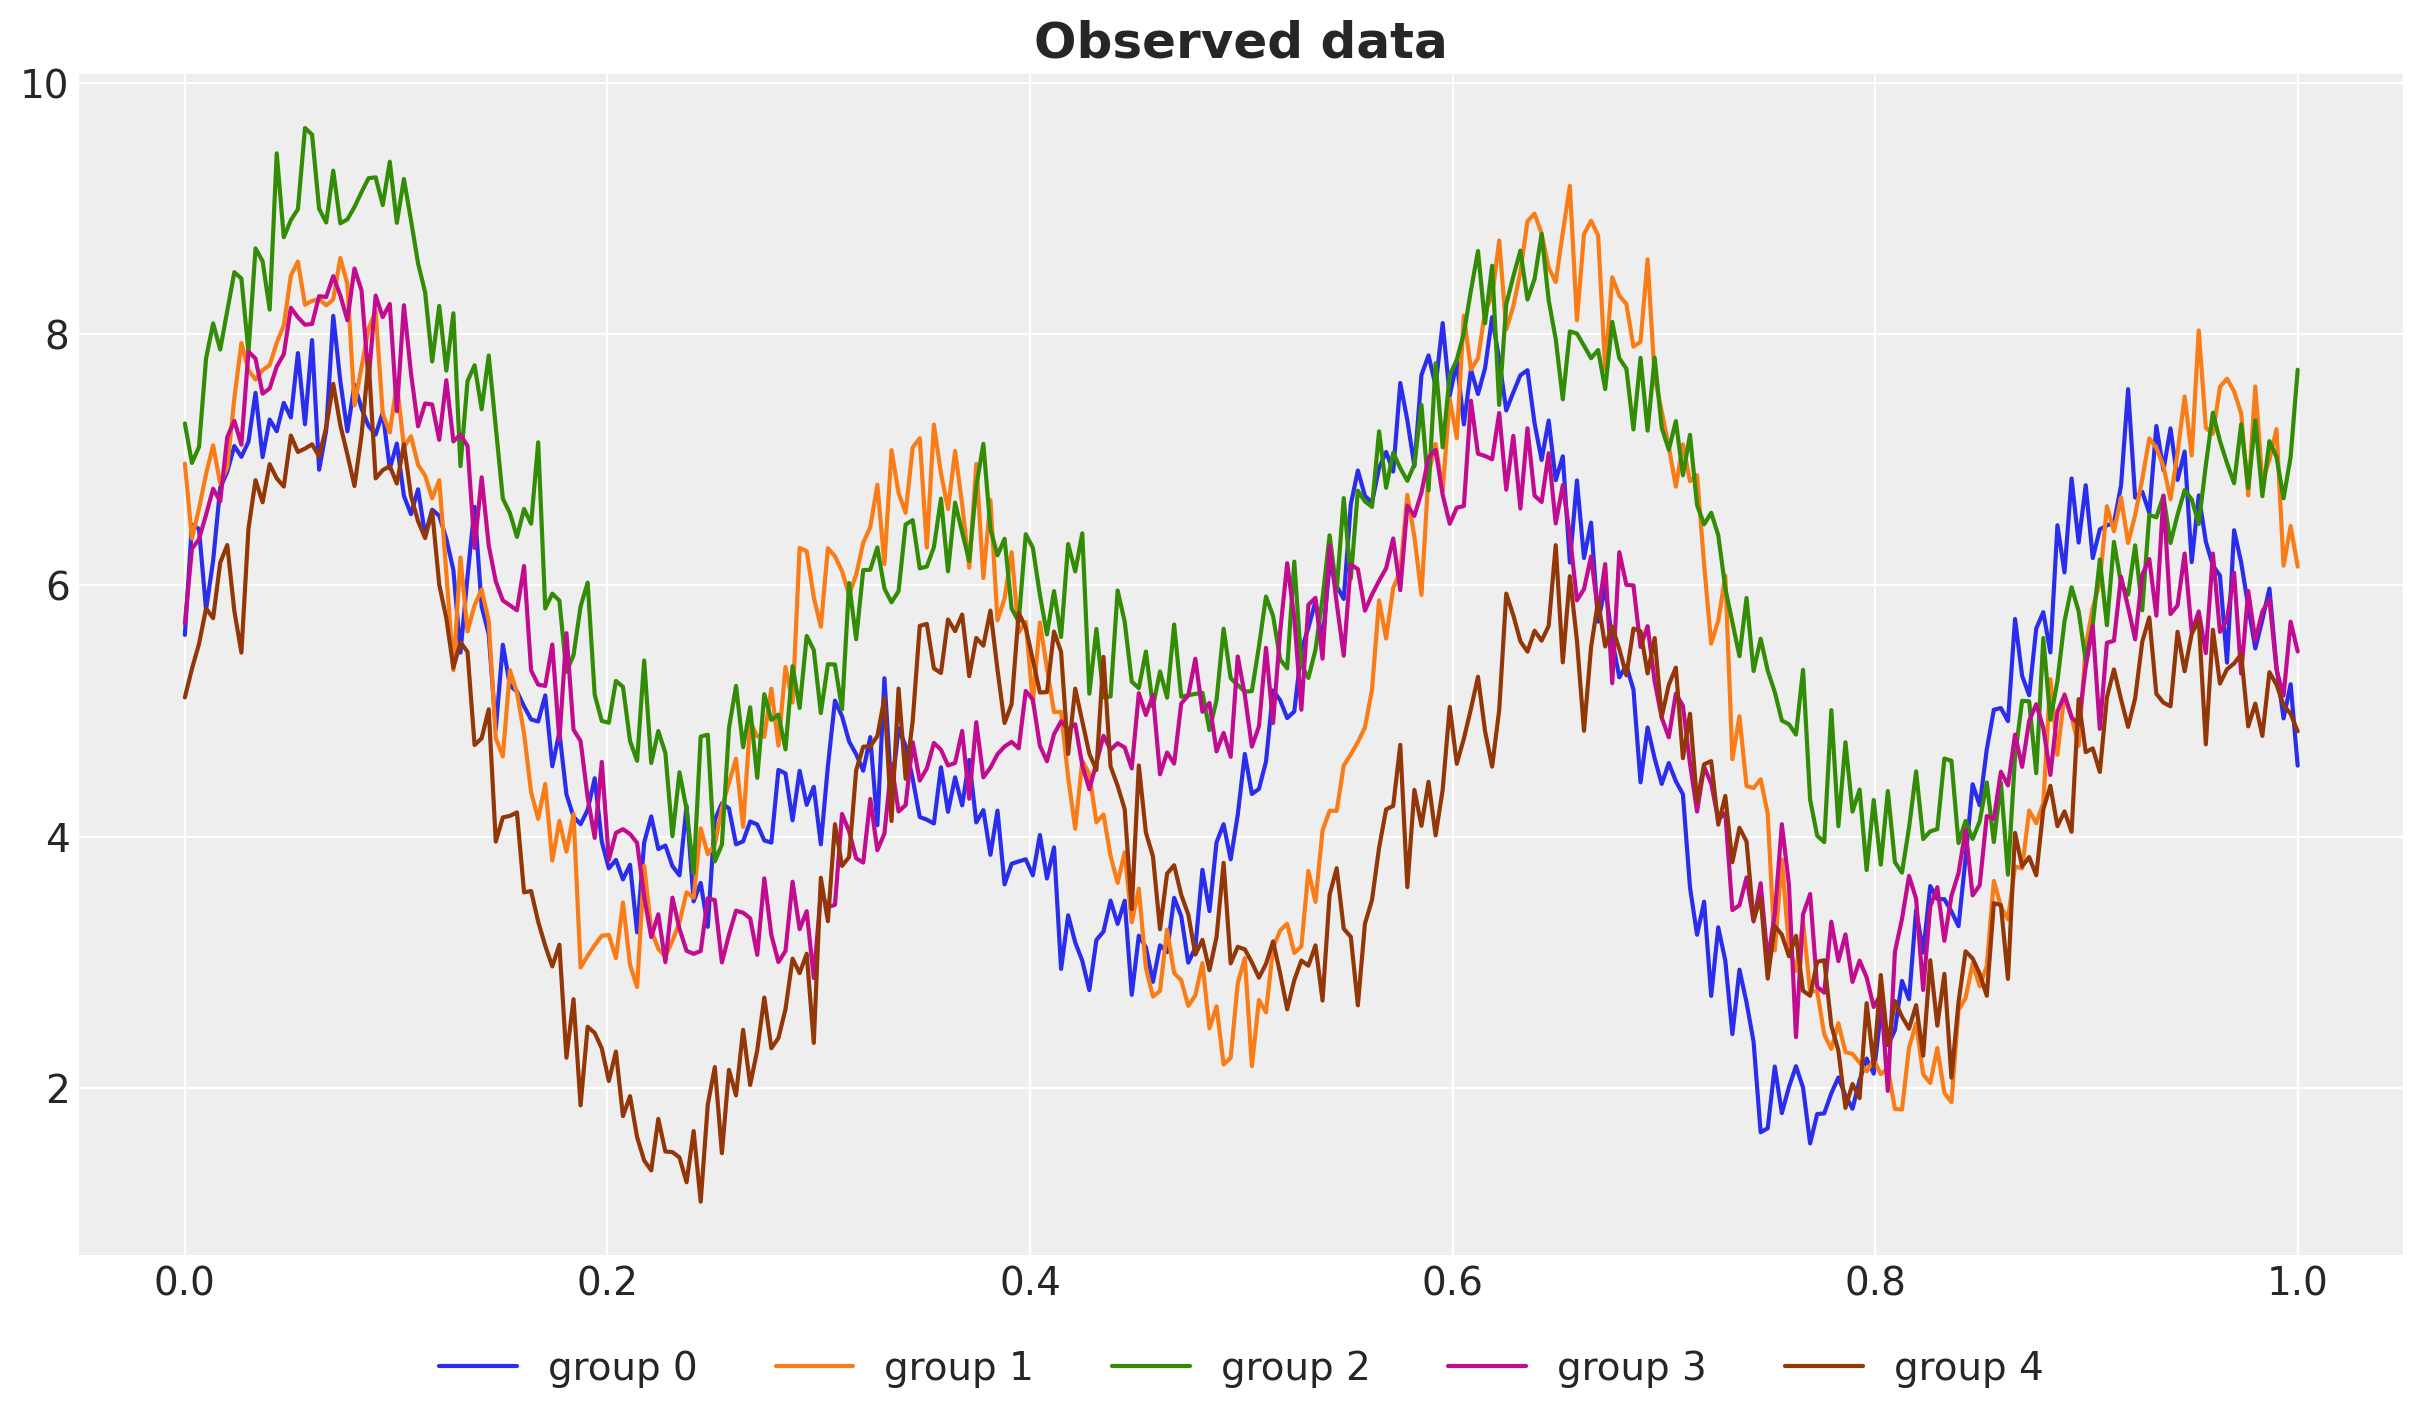

In [4]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"group {g}")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data", fontsize=18, fontweight="bold");

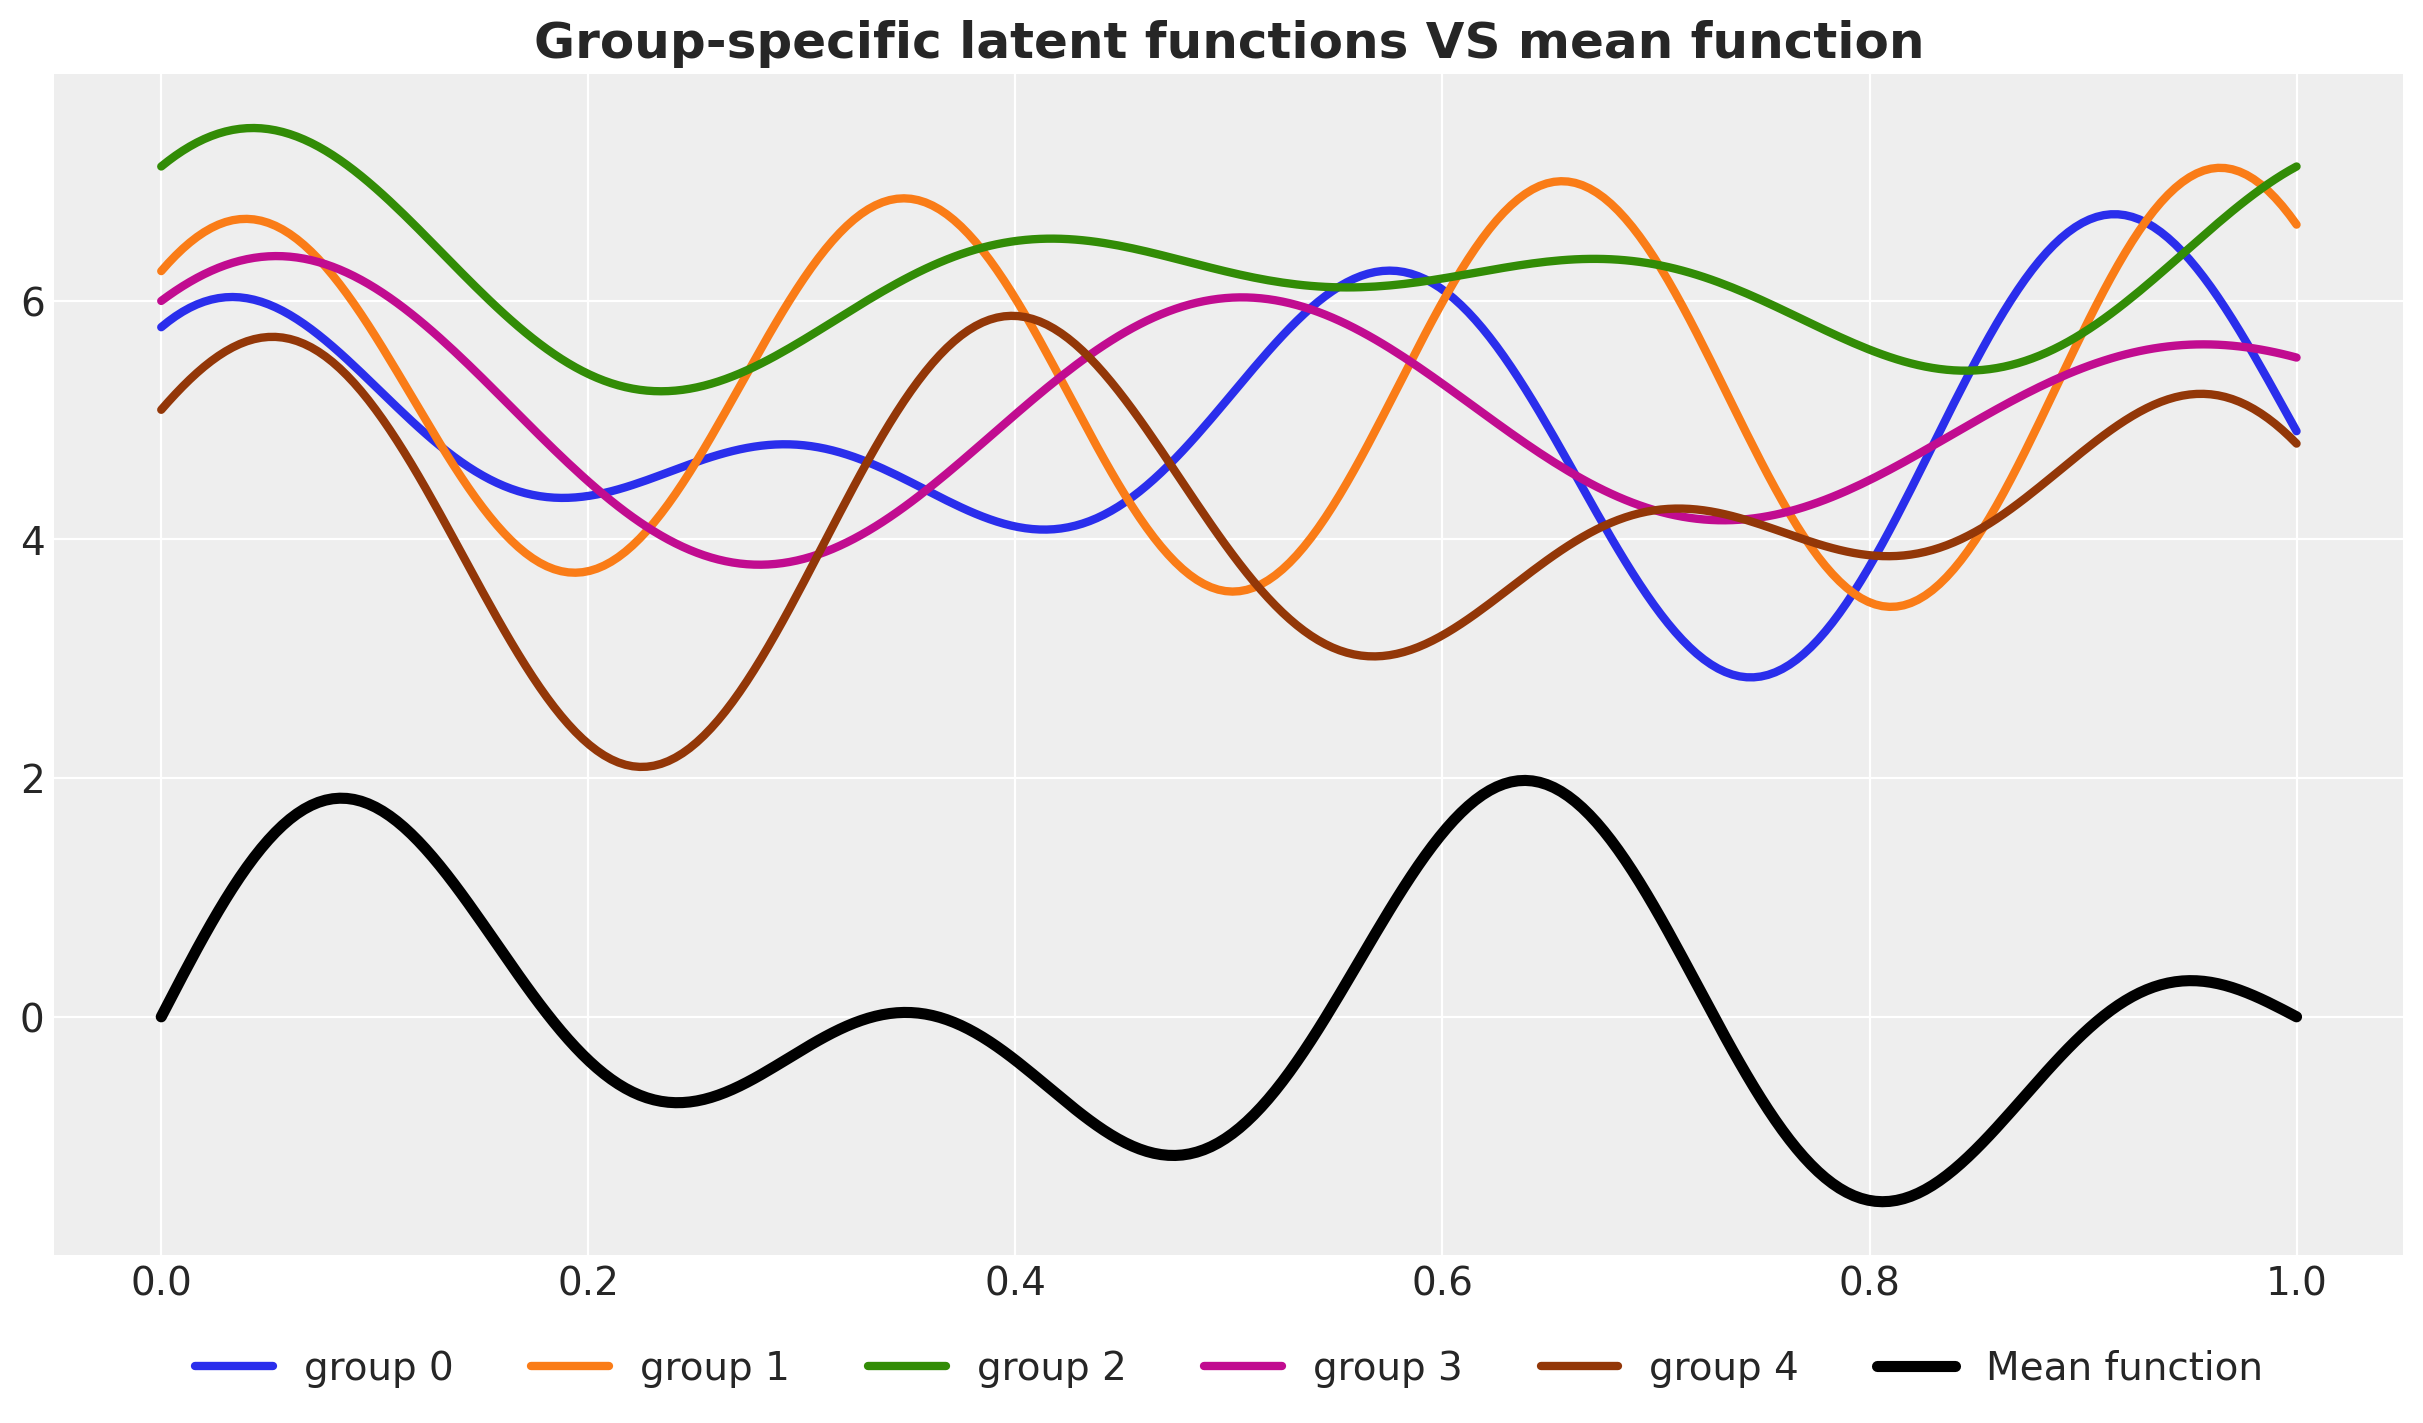

In [5]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);

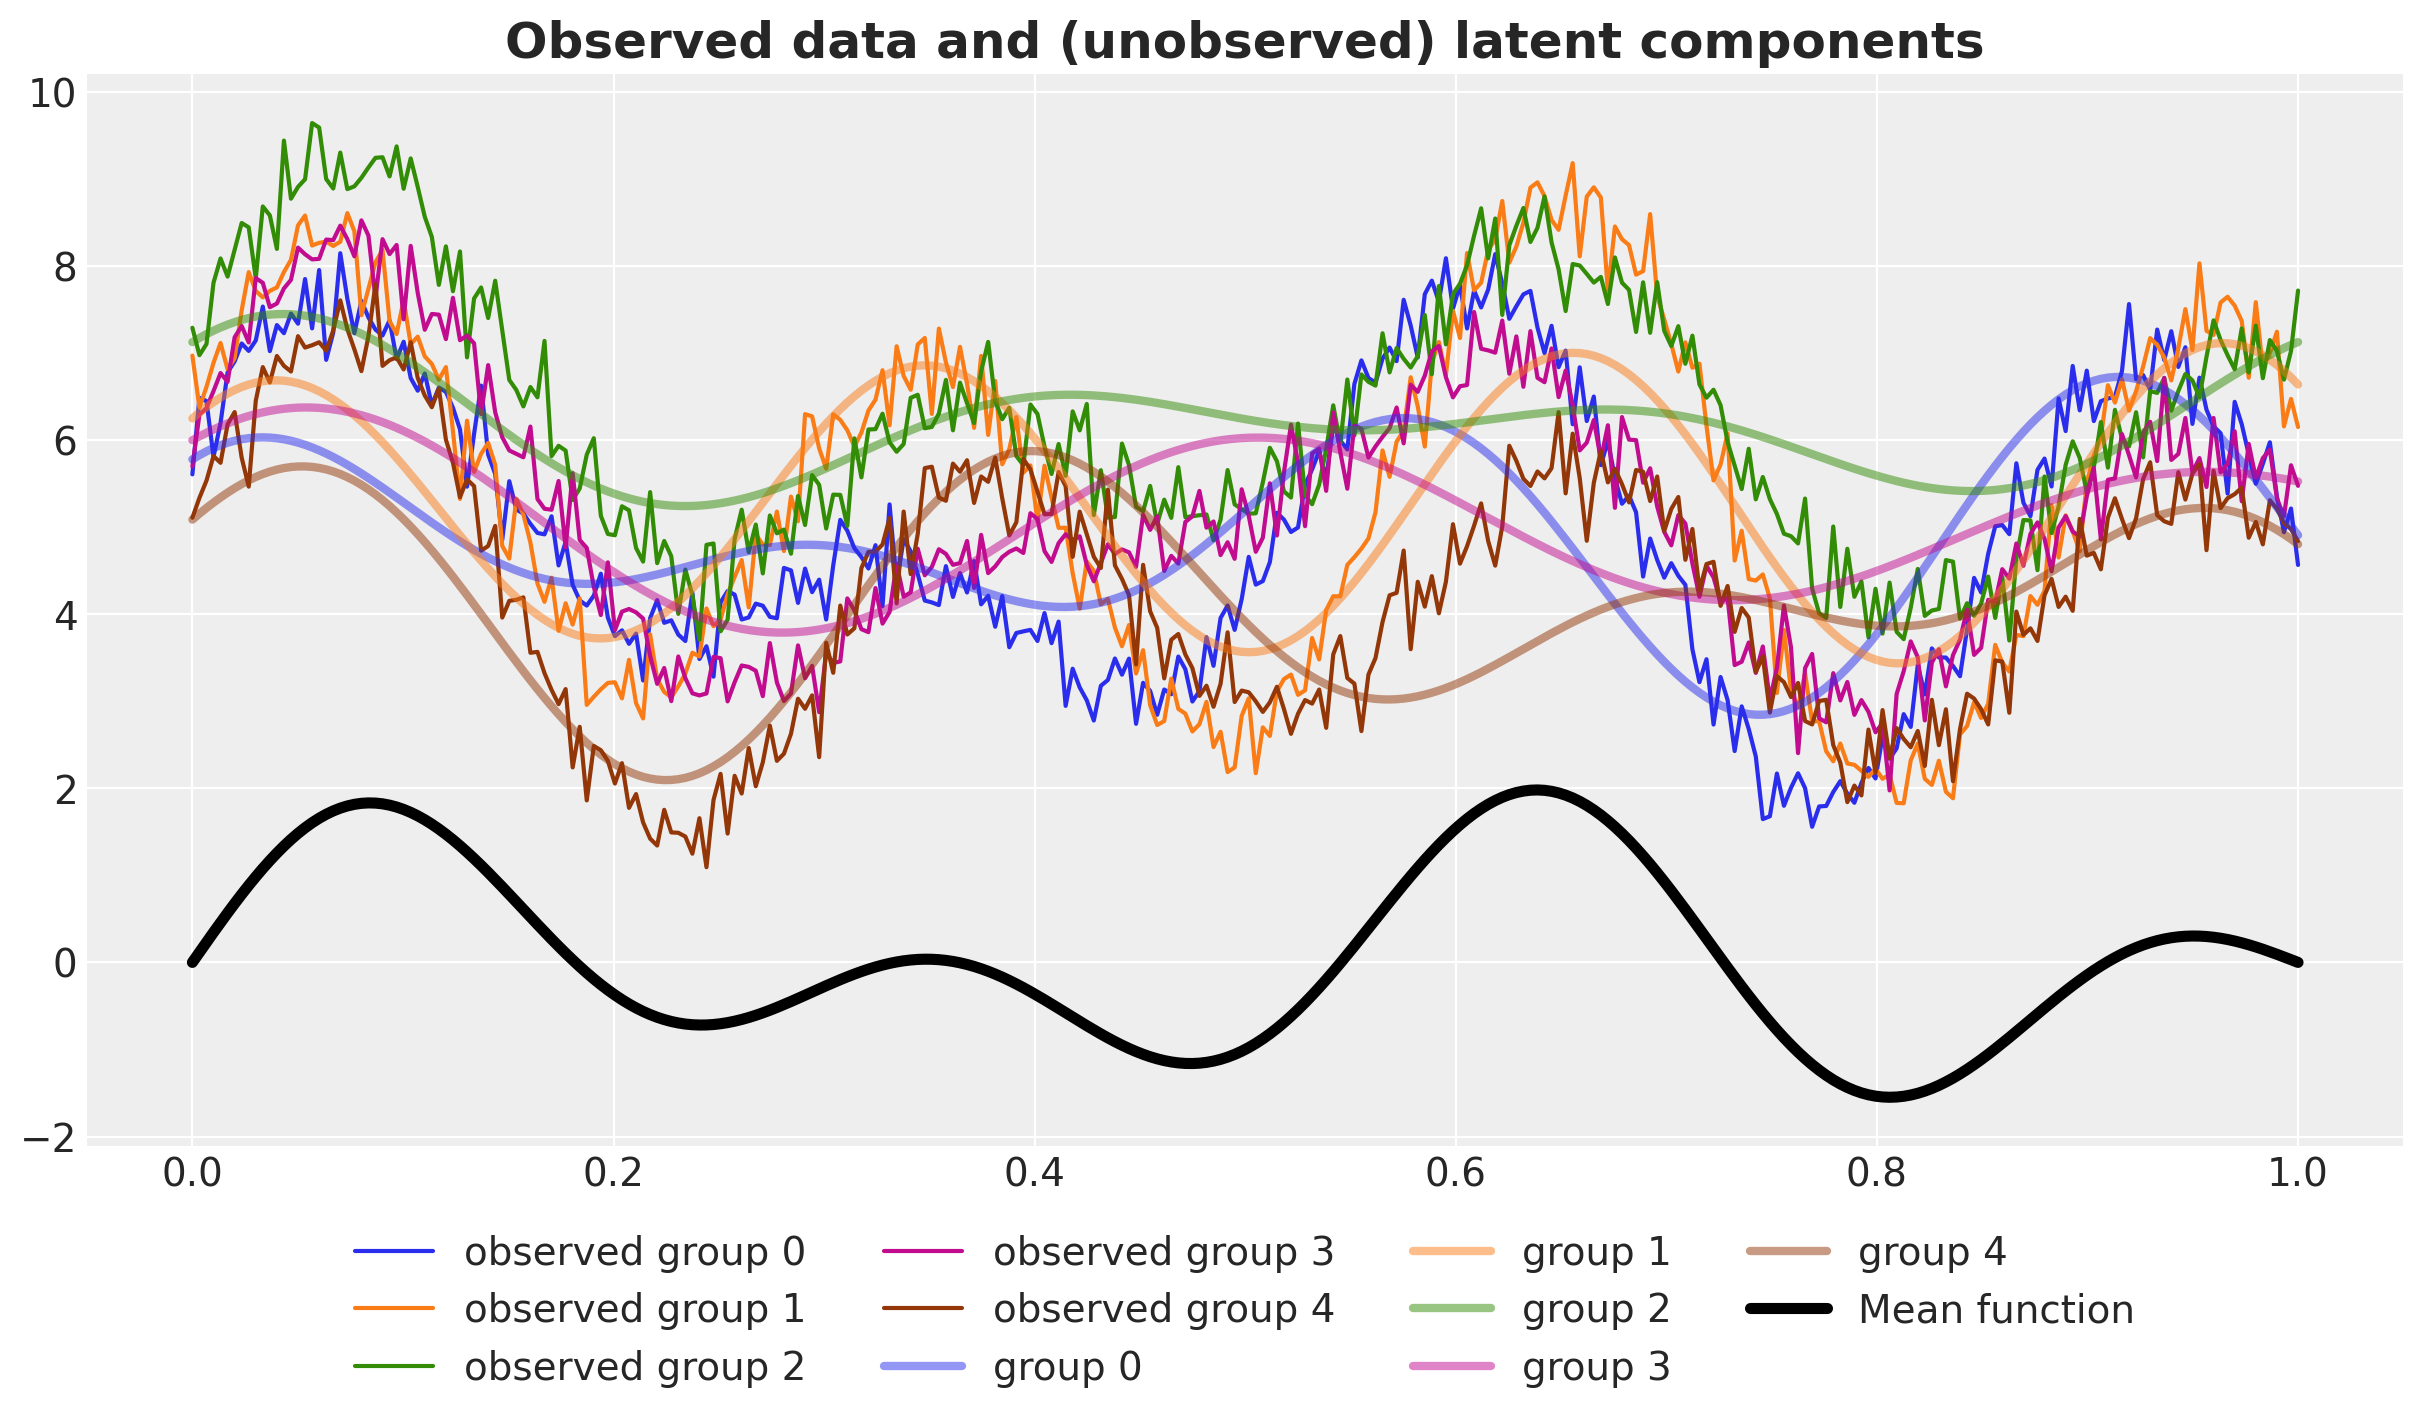

In [6]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"observed group {g}")

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", alpha=0.5, label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups - 1)
ax.set_title(
    "Observed data and (unobserved) latent components", fontsize=18, fontweight="bold"
);

## Train Test Split

In [7]:
n_train = 260

x_train = x[:n_train]
x_test = x[n_train:]

y_train = y[:, :n_train]
y_test = y[:, n_train:]

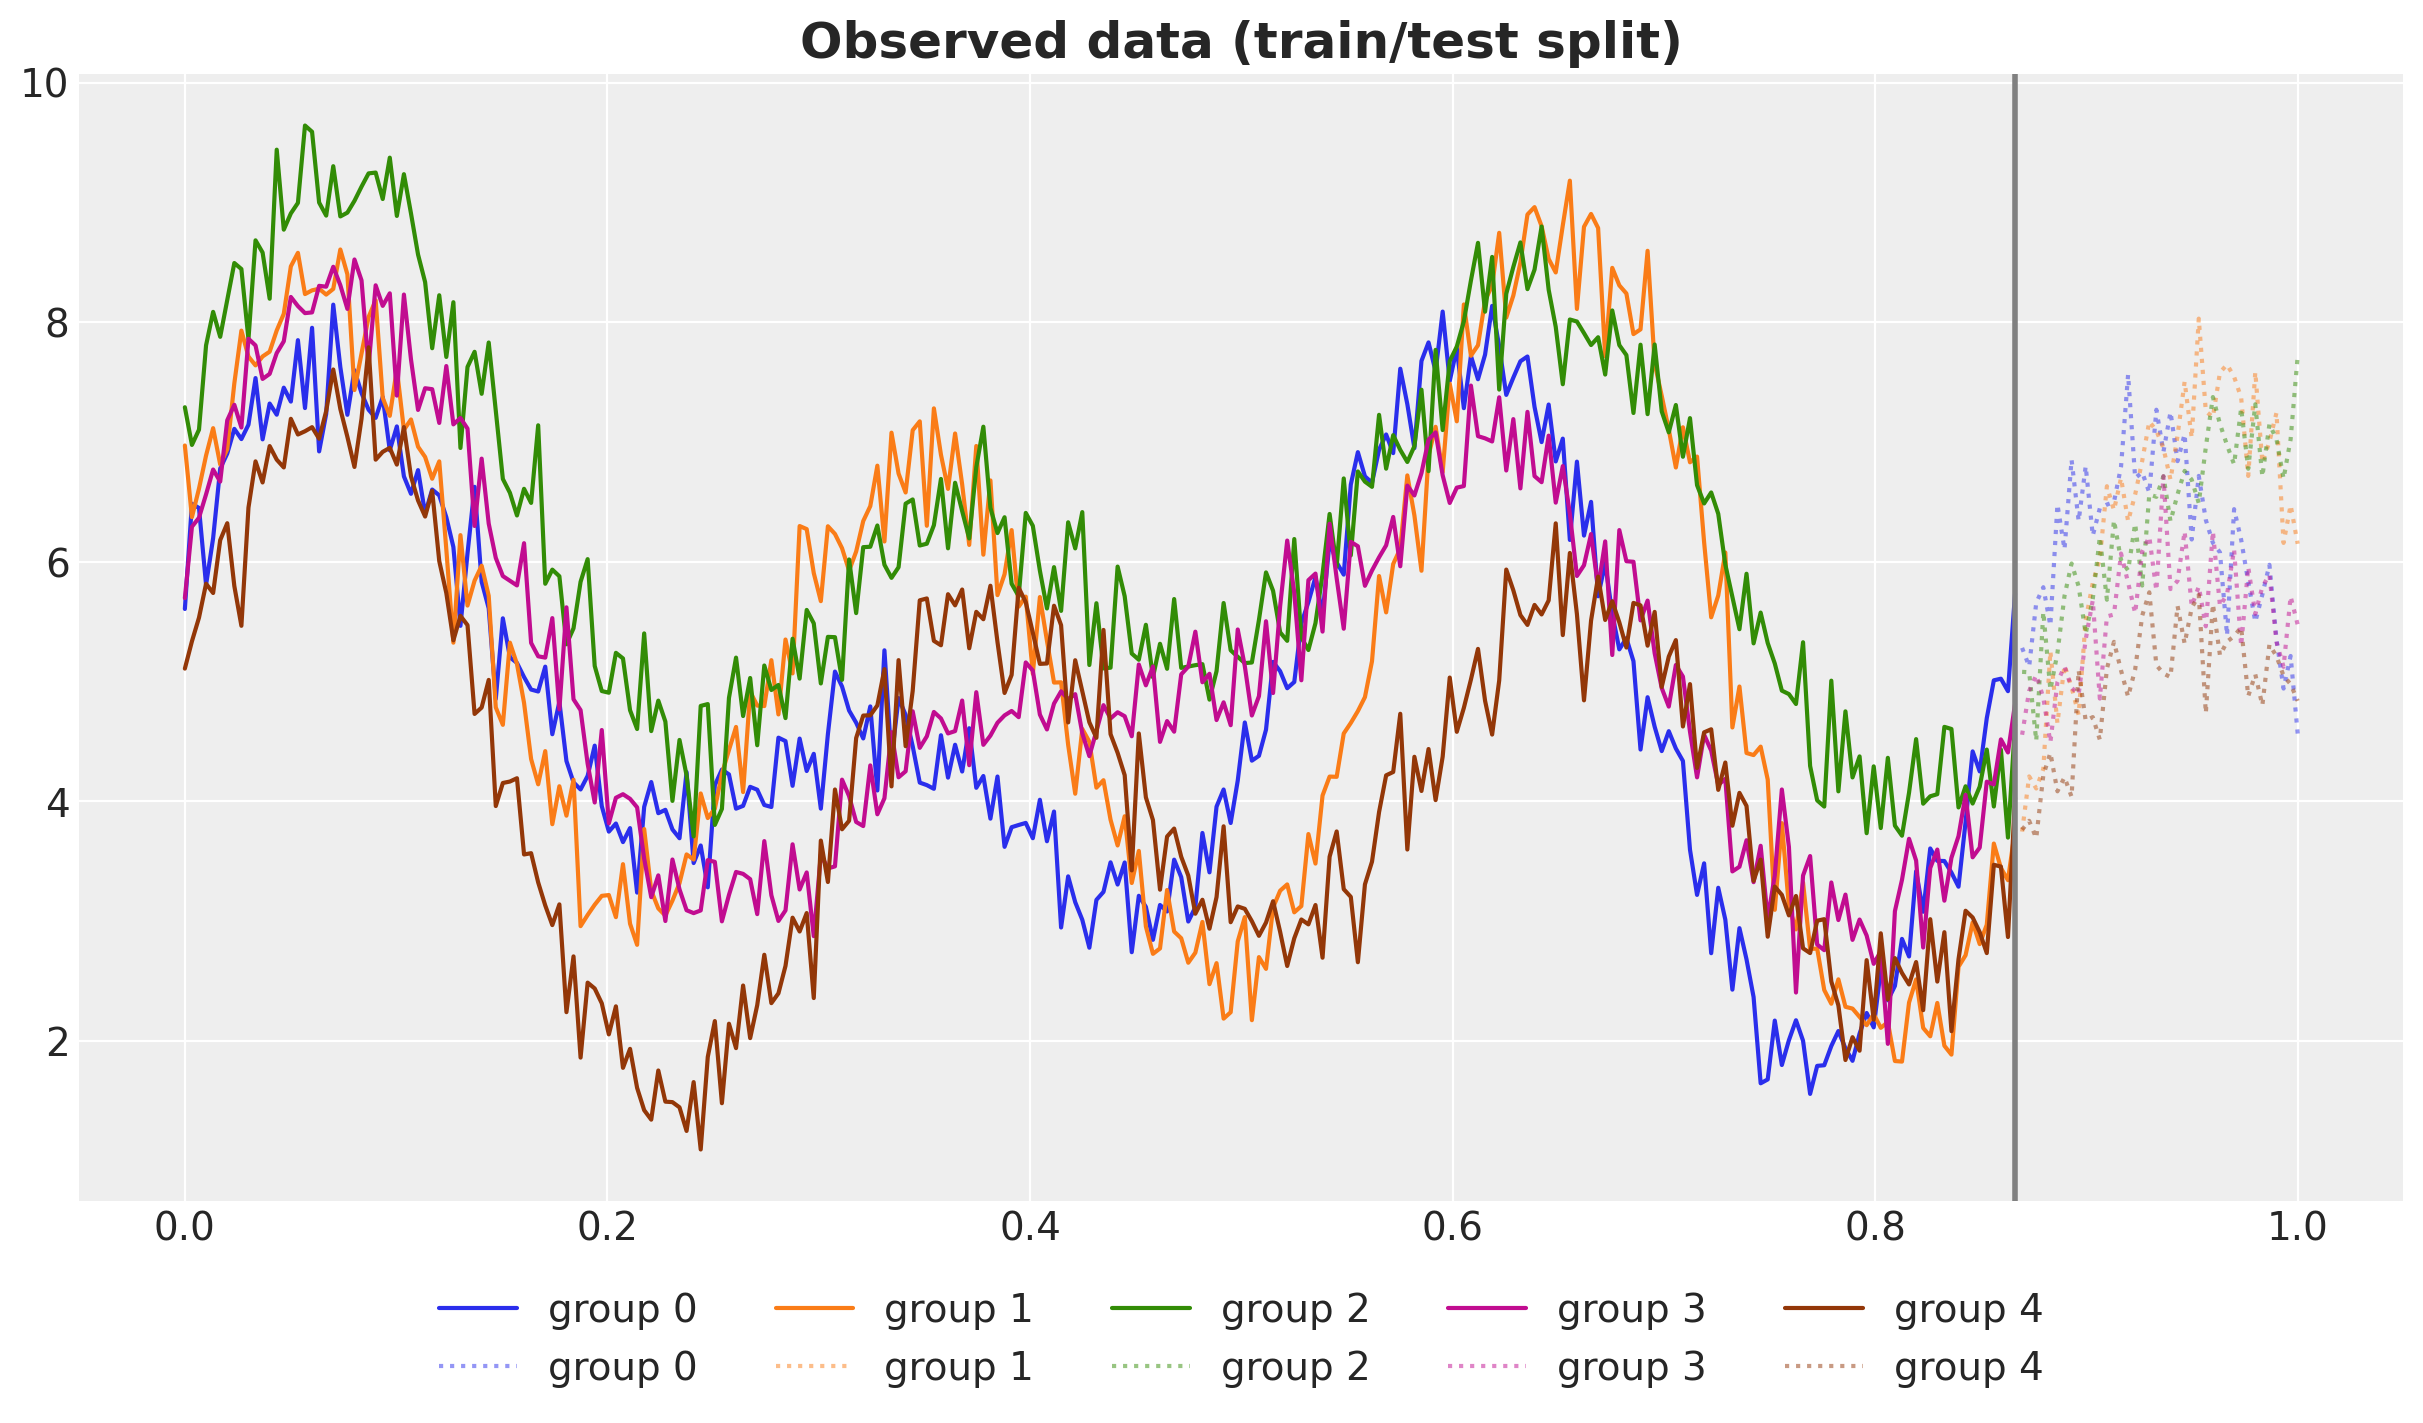

In [8]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")
    ax.plot(x_test, y_test[g], c=f"C{g}", ls="dotted", alpha=0.5, label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data (train/test split)", fontsize=18, fontweight="bold");

## Model Specification

In [9]:
def diag_spectral_density_squared_exponential_vectorized(alpha, length, ell, m, dim):
    theta = jnp.stack([alpha, length], axis=0)
    return vmap(
        lambda theta: diag_spectral_density_squared_exponential(
            alpha=theta[0],  # alpha,
            length=theta[1],  # length,
            ell=ell,
            m=m,
            dim=dim,
        ),
        in_axes=-1,
    )(theta)

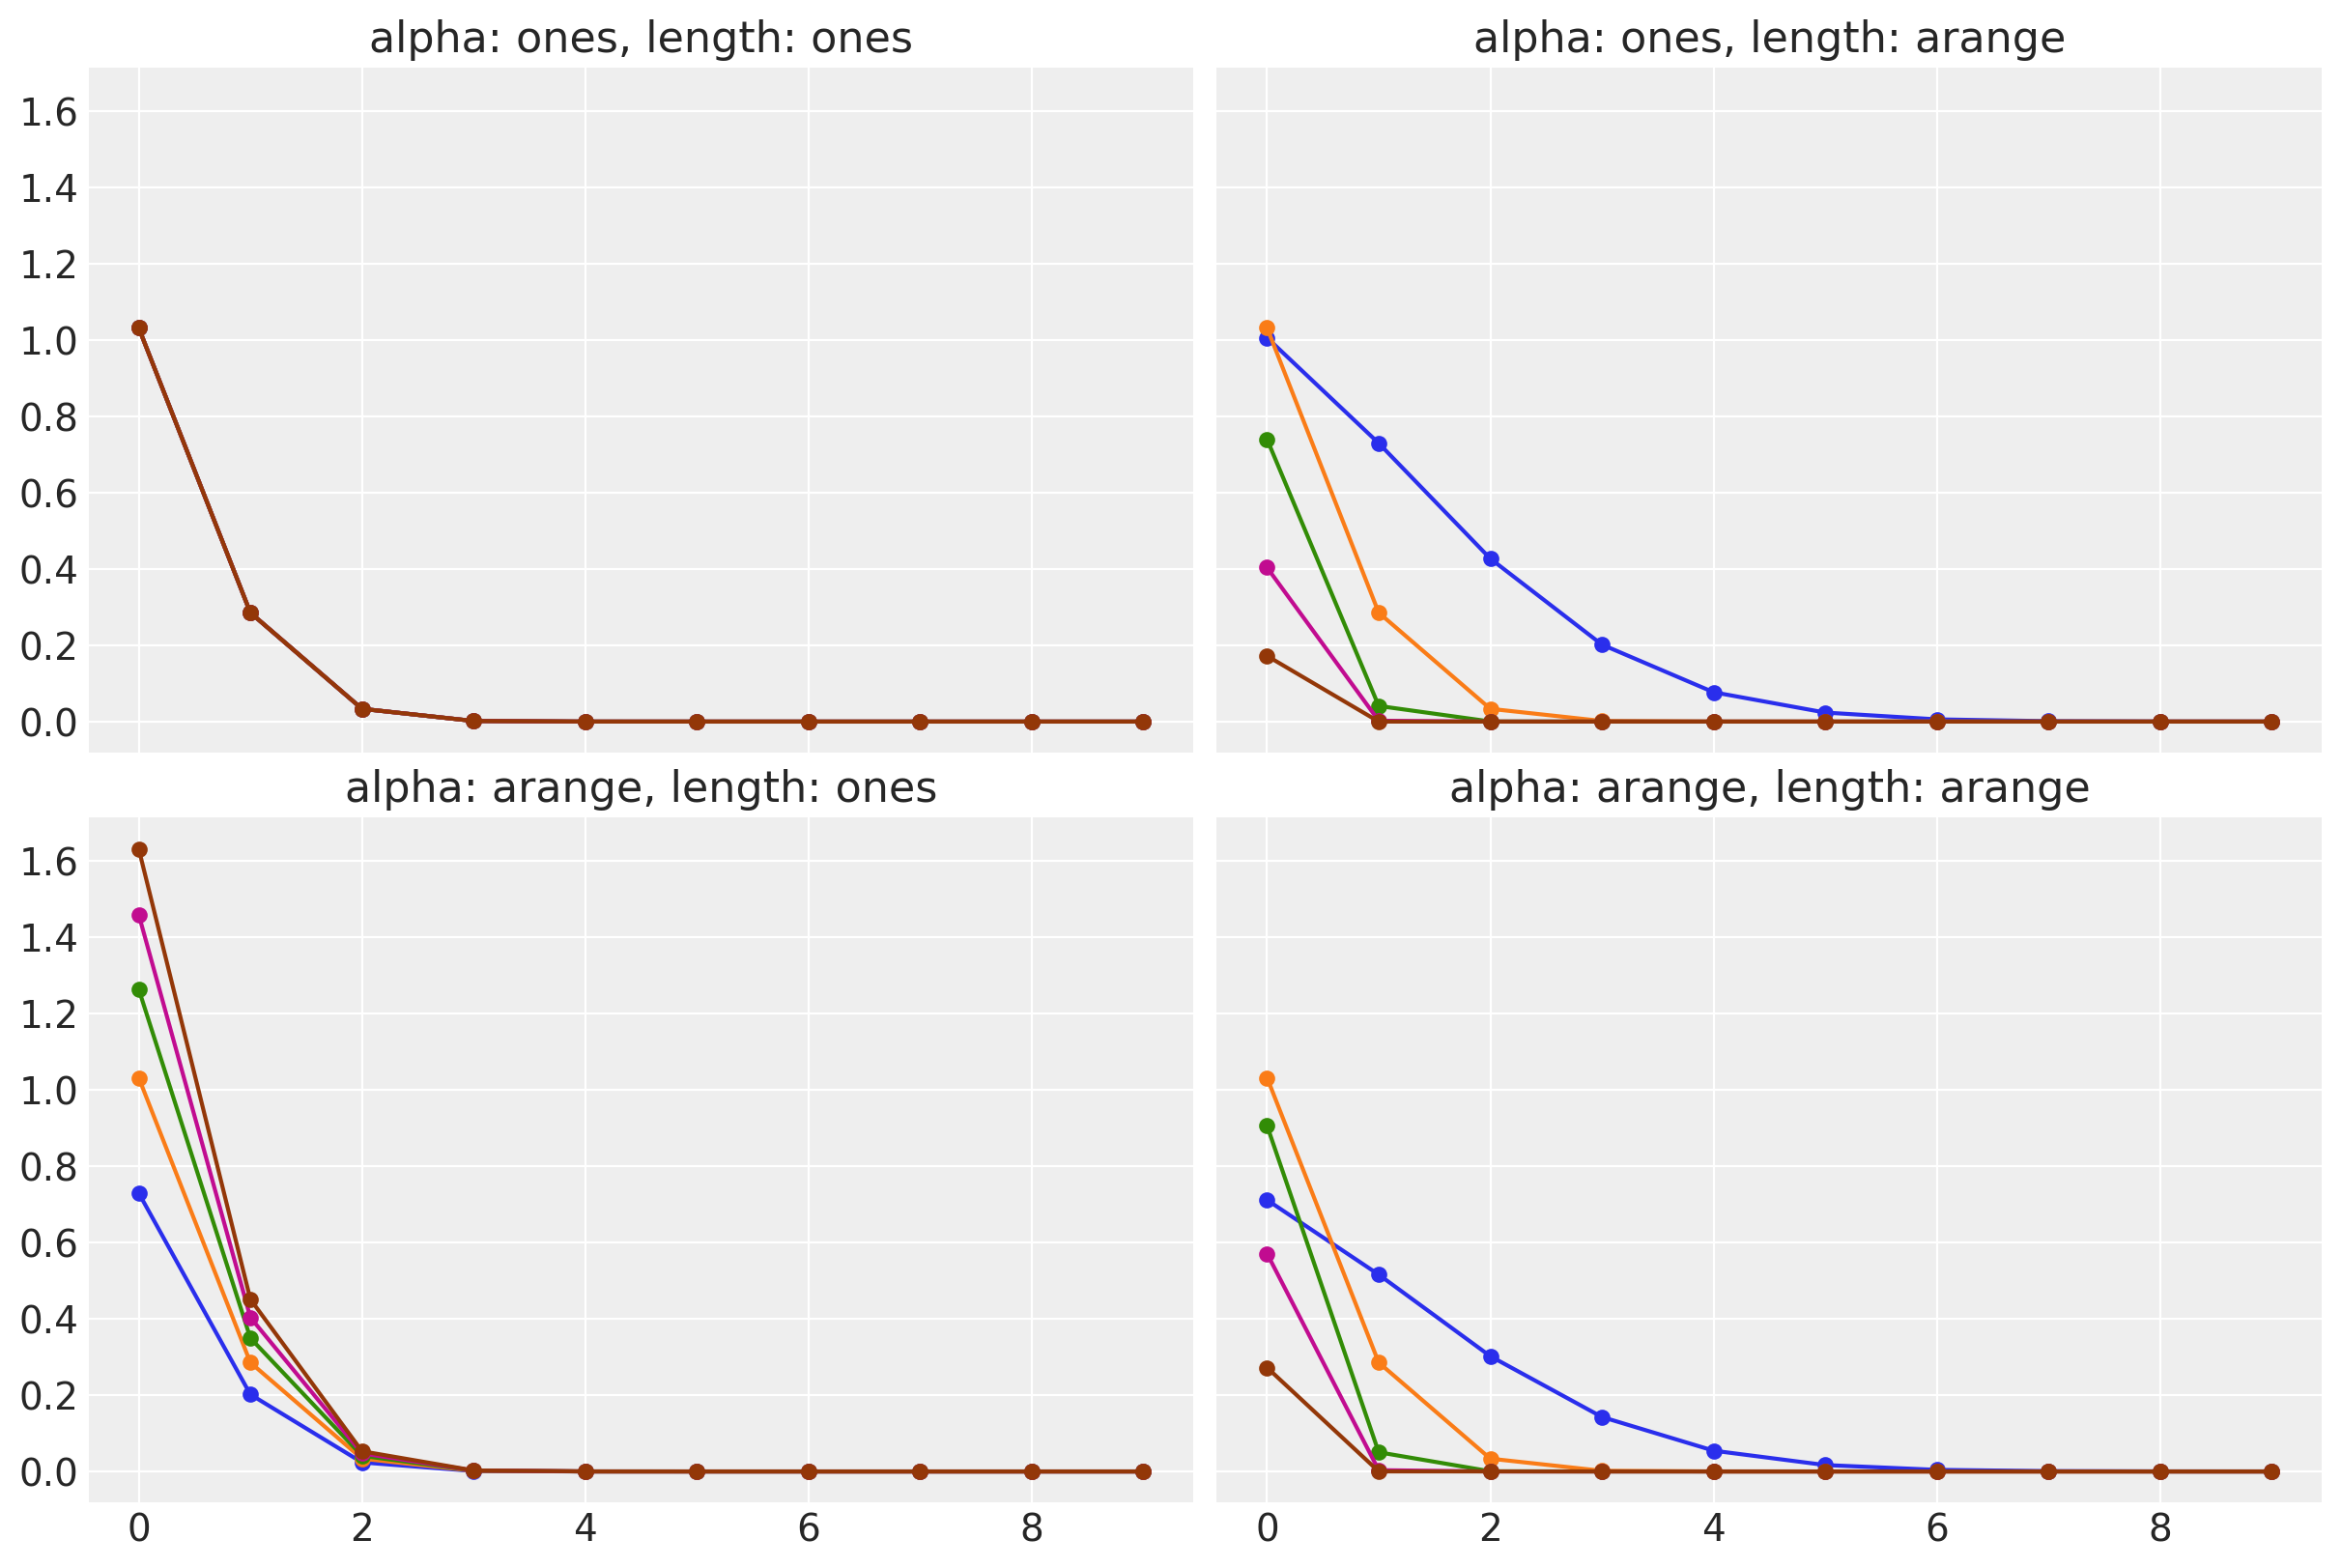

In [10]:
ell = 1.2
m = 10
dim = 1

ones_array = jnp.ones(n_groups)
arange_array = 0.5 * jnp.arange(start=1, stop=n_groups + 1, step=1)


fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True, layout="constrained"
)

for i, alpha in enumerate([ones_array, arange_array]):
    for j, length in enumerate([ones_array, arange_array]):
        spd = jnp.sqrt(
            diag_spectral_density_squared_exponential_vectorized(
                alpha=alpha,
                length=length,
                ell=ell,
                m=m,
                dim=dim,
            )
        )

        assert spd.shape == (n_groups, m)

        ax = axes[i, j]

        alpha_label = "ones" if i == 0 else "arange"
        length_label = "ones" if j == 0 else "arange"

        for g in range(n_groups):
            ax.plot(spd[g], c=f"C{g}", marker="o", markersize=5, label=f"group {g}")

        ax.set_title(f"alpha: {alpha_label}, length: {length_label}")

In [11]:
spd = jnp.sqrt(
    diag_spectral_density_squared_exponential_vectorized(
        alpha=arange_array,
        length=arange_array,
        ell=ell,
        m=m,
        dim=dim,
    )
)

for i, (single_alpha, single_length) in enumerate(
    zip(arange_array, arange_array, strict=True)
):
    assert jnp.array_equal(
        spd[i],
        jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=single_alpha, length=single_length, ell=ell, m=m, dim=dim
            )
        ),
    )

In [12]:
def global_hsgp(x, ell, m):
    alpha_global = numpyro.sample(
        "alpha_global", dist.InverseGamma(concentration=12, rate=10)
    )
    length_global = numpyro.sample(
        "length_global", dist.InverseGamma(concentration=6, rate=1)
    )

    return numpyro.deterministic(
        "f_mean",
        hsgp_squared_exponential(
            x=x,
            alpha=alpha_global,
            length=length_global,
            ell=ell,
            m=m,
            non_centered=True,
        ),
    )


def group_deltas_hsgp(y, x, ell, m):
    n_groups, _ = y.shape

    groups_plate = numpyro.plate("groups", n_groups)

    with groups_plate:
        alpha_groups = numpyro.sample(
            "alpha_groups", dist.InverseGamma(concentration=12, rate=10)
        )
        length_groups = numpyro.sample(
            "length_groups", dist.InverseGamma(concentration=6, rate=1)
        )

        group_intercepts = numpyro.sample(
            "group_intercepts", dist.Normal(loc=0.0, scale=1.0)
        )

    phi = eigenfunctions(x=x, ell=ell, m=m)

    spd = jnp.sqrt(
        diag_spectral_density_squared_exponential_vectorized(
            alpha=alpha_groups, length=length_groups, ell=ell, m=m, dim=dim
        )
    )

    with groups_plate, numpyro.plate("basis", m):
        beta_delta = numpyro.sample("beta_deltas", dist.Normal(loc=0.0, scale=1.0))

    return numpyro.deterministic(
        "f_delta", (phi @ (spd.T * beta_delta)).T + group_intercepts[..., None]
    )


def model(x, y, ell, m) -> None:
    n_groups, n_obs = y.shape

    scale = numpyro.sample("scale", dist.InverseGamma(concentration=12, rate=10))

    f_mean = global_hsgp(x, ell, m)

    f_delta = group_deltas_hsgp(y, x, ell, m)

    f_group = numpyro.deterministic("f", f_mean + f_delta)

    with numpyro.plate("data", n_obs):
        numpyro.sample("obs", dist.Normal(loc=f_group, scale=scale), obs=y)


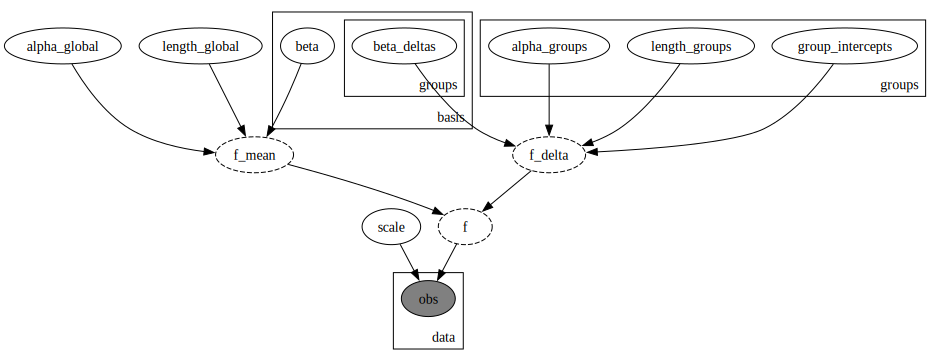

In [13]:
numpyro.render_model(model, model_args=(x_train, y_train, 1.5, 10))

In [14]:
prior_predictive = Predictive(model, num_samples=100)

prior_predictive_samples = prior_predictive(rng_key, x_train, y_train, 1.5, 10)